In [ ]:
from llavart.models.mllm.qwen2_5_vl import Qwen2_5_VLChatModel
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
import torch
from PIL import Image
from transformers import AutoTokenizer

/leonardo/home/userexternal/nfanelli/miniconda3/envs/llavart/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = Qwen2_5_VLChatModel.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading checkpoint shards: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


In [3]:
print(model.processor.chat_template)

{% set image_count = namespace(value=0) %}{% set video_count = namespace(value=0) %}{% for message in messages %}{% if loop.first and message['role'] != 'system' %}<|im_start|>system
You are a helpful assistant.<|im_end|>
{% endif %}<|im_start|>{{ message['role'] }}
{% if message['content'] is string %}{{ message['content'] }}<|im_end|>
{% else %}{% for content in message['content'] %}{% if content['type'] == 'image' or 'image' in content or 'image_url' in content %}{% set image_count.value = image_count.value + 1 %}{% if add_vision_id %}Picture {{ image_count.value }}: {% endif %}<|vision_start|><|image_pad|><|vision_end|>{% elif content['type'] == 'video' or 'video' in content %}{% set video_count.value = video_count.value + 1 %}{% if add_vision_id %}Video {{ video_count.value }}: {% endif %}<|vision_start|><|video_pad|><|vision_end|>{% elif 'text' in content %}{{ content['text'] }}{% endif %}{% endfor %}<|im_end|>
{% endif %}{% endfor %}{% if add_generation_prompt %}<|im_start|>assi

In [4]:
tt = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct")
tt.chat_template

'{%- if tools %}\n    {{- \'<|im_start|>system\\n\' }}\n    {%- if messages[0][\'role\'] == \'system\' %}\n        {{- messages[0][\'content\'] }}\n    {%- else %}\n        {{- \'You are Qwen, created by Alibaba Cloud. You are a helpful assistant.\' }}\n    {%- endif %}\n    {{- "\\n\\n# Tools\\n\\nYou may call one or more functions to assist with the user query.\\n\\nYou are provided with function signatures within <tools></tools> XML tags:\\n<tools>" }}\n    {%- for tool in tools %}\n        {{- "\\n" }}\n        {{- tool | tojson }}\n    {%- endfor %}\n    {{- "\\n</tools>\\n\\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\\n<tool_call>\\n{\\"name\\": <function-name>, \\"arguments\\": <args-json-object>}\\n</tool_call><|im_end|>\\n" }}\n{%- else %}\n    {%- if messages[0][\'role\'] == \'system\' %}\n        {{- \'<|im_start|>system\\n\' + messages[0][\'content\'] + \'<|im_end|>\\n\' }}\n    {%- else %}\n       

In [5]:
with open("template2.txt", "r") as f:
    chat_template = f.read()

In [6]:
chat_template

'{%- set image_count = namespace(value=0) -%}\n{%- set video_count = namespace(value=0) -%}\n{%- macro render_content(message) -%}\n    {%- if message[\'content\'] is string -%}\n        {{- message[\'content\'] -}}\n    {%- else -%}\n        {%- for content in message[\'content\'] -%}\n            {%- if content[\'type\'] == \'image\' or \'image\' in content or \'image_url\' in content -%}\n                {%- set image_count.value = image_count.value + 1 -%}\n                {%- if add_vision_id -%}\n                    {{- \'Picture \' ~ image_count.value ~ \':\' -}}\n                {%- endif -%}\n                {{- \'<|vision_start|><|image_pad|><|vision_end|>\' -}}\n            {%- elif content[\'type\'] == \'video\' or \'video\' in content -%}\n                {%- set video_count.value = video_count.value + 1 -%}\n                {%- if add_vision_id -%}\n                    {{- \'Video \' ~ video_count.value ~ \':\' -}}\n                {%- endif -%}\n                {{- \'<|v

In [7]:
model.processor.chat_template = chat_template

In [50]:
import json

def get_current_temperature(location: str, unit: str = "celsius"):
    """Get the current temperature for the given location.

    Args:
        location: The location to get the temperature for, in the format "City, State, Country".
        unit: The unit to return the temperature in. Defaults to "celsius". (choices: ["celsius", "fahrenheit"])

    Returns:
        the temperature, the location, and the unit in a dict
    """
    return {
        "temperature": 26.1,
        "location": location,
        "unit": unit,
    }


def get_temperature_forecast_by_date(location: str, date: str, unit: str = "celsius"):
    """Obtain a temperature forecast for the given location on the specified future date.

    Args:
        location: The location to get the temperature for, in the format "City, State, Country".
        date: The date to get the temperature for, in the format "Year-Month-Day".
        unit: The unit to return the temperature in. Defaults to "celsius". (choices: ["celsius", "fahrenheit"])

    Returns:
        the temperature, the location, the date and the unit in a dict
    """
    return {
        "temperature": 25.9,
        "location": location,
        "date": date,
        "unit": unit,
    }

In [51]:
tools = [get_current_temperature, get_temperature_forecast_by_date]

In [52]:
model = model.bind_tools(tools)

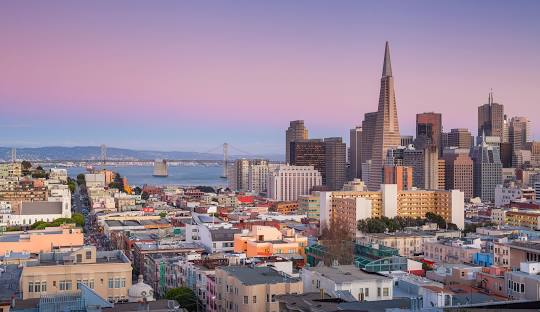

In [53]:
image = Image.open("data/images/sf.jpeg")
image

In [54]:
messages = [
    SystemMessage(
        content=[
            {
                "type": "text",
                "text": "You are a helpful assistant.\n\nCurrent Date: 2025-02-18"
            }
        ] 
    ),
    HumanMessage(
        content=[
            {"type": "image"},
            {"type": "text", "text": "Given the city in the image, what is the temperature in that city today? What about tomorrow?"},
        ]
    ),
]

In [55]:
def call_tools(response, messages):
    if tool_calls := getattr(response, "tool_calls", None):
        for tool_call in tool_calls:
            fn_name = tool_call["name"]
            fn_args = tool_call["args"]

            # Find the matching tool by name
            tool = next((t for t in tools if t.__name__ == fn_name), None)
            if tool is not None:
                fn_res: str = json.dumps(tool(**fn_args))
            else:
                raise ValueError(f"Tool {fn_name} not found")

            # hf_messages.append(
            #     {
            #         "role": "tool",
            #         "name": fn_name,
            #         "content": fn_res,
            #     }
            # )
            messages.append(
                ToolMessage(
                    tool_call_id=tool_call["id"],
                    name=fn_name,
                    content=fn_res,
                )
            )
        return True
    return False

In [56]:
response = model.invoke(messages, images=[image], max_new_tokens=1024)
messages.append(response)
while(call_tools(response, messages)):
    response = model.invoke(messages, images=[image], max_new_tokens=1024)
    messages.append(response)
response

[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a helpful assistant.\n\nCurrent Date: 2025-02-18'}]}, {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Given the city in the image, what is the temperature in that city today? What about tomorrow?'}]}]
<|im_start|>system\nYou are a helpful assistant.

Current Date: 2025-02-18\n\n# Tools\n\nYou may call one or more functions to assist with the user query.\n\nYou are provided with function signatures within <tools></tools> XML tags:\n<tools>\n{"type": "function", "function": {"name": "get_current_temperature", "description": "Get the current temperature for the given location.", "parameters": {"type": "object", "properties": {"location": {"type": "string", "description": "The location to get the temperature for, in the format \"City, State, Country\"."}, "unit": {"type": "string", "enum": ["celsius", "fahrenheit"], "description": "The unit to return the temperature in. Defaults to \"celsius\"."}}, 

AIMessage(content='The temperature forecast for tomorrow (February 19, 2025) in San Francisco, CA, USA is 25.9°C.', additional_kwargs={}, response_metadata={}, id='run-4d2bacda-22f3-4aa2-a346-b0c4f2cf7137-0')

In [57]:
messages

[SystemMessage(content=[{'type': 'text', 'text': 'You are a helpful assistant.\n\nCurrent Date: 2025-02-18'}], additional_kwargs={}, response_metadata={}),
 HumanMessage(content=[{'type': 'image'}, {'type': 'text', 'text': 'Given the city in the image, what is the temperature in that city today? What about tomorrow?'}], additional_kwargs={}, response_metadata={}),
 AIMessage(content="To provide you with the current temperature and the temperature forecast for tomorrow in San Francisco, I will use the `get_current_temperature` and `get_temperature_forecast_by_date` functions.\n\nFirst, let's get the current temperature in San Francisco:\n\n", additional_kwargs={}, response_metadata={}, id='run-b9d2edcc-cfaf-4eed-9804-c7ffd07aca0d-0', tool_calls=[{'name': 'get_current_temperature', 'args': {'location': 'San Francisco, CA, USA'}, 'id': 'call_vIWKw7sA5UWb8mmyfGr2nIvw', 'type': 'tool_call'}]),
 ToolMessage(content='{"temperature": 26.1, "location": "San Francisco, CA, USA", "unit": "celsius